<a href="https://colab.research.google.com/github/EtzionR/LM4GeoAI/blob/main/Geo_Semantic_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ex 1: Geo-Semantic Search
### created by Etzion Harari | Geo-AI Course

[**https://github.com/EtzionR/LM4GeoAI**](https://github.com/EtzionR/LM4GeoAI)

## Prerequisites: pip install osmnx
[https://osmnx.readthedocs.io/en/stable/](https://osmnx.readthedocs.io/en/stable/)

In [1]:
!pip install osmnx

## Imports

In [2]:
from pandas.errors import SettingWithCopyWarning
from shapely import Point, Polygon
from time import time as get_time
from transformers import pipeline
from tqdm import tqdm

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import osmnx as ox
import numpy as np
import warnings
import folium

## Ignore pandas Warning

In [3]:
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

## Global variables: EPSG codes (define the spatial reference systems)

In [4]:
WGS84_UTM_31N = "EPSG:32631"
WGS84_GEO_DD  = "EPSG:4326"


## Define Food type place_type in OSM data

In [5]:
FOOD = {'restaurant','fast_food','cafe'}
FOOD

{'cafe', 'fast_food', 'restaurant'}

### Eiffel Tower Location
WGS84 GEO DD X = 2.2944492, Y = 48.8583088

WGS84 GEO UTM 31N X = 448248, Y = 5411944

In [6]:
EIFFEL = Point(448248, 5411944)

## Display Eiffel Tower on the map

In [7]:

eiffecl_wgs84_dd = gpd.GeoSeries([EIFFEL], crs=WGS84_UTM_31N).to_crs(WGS84_GEO_DD).iloc[0]

eiffel_x, eiffel_y = eiffecl_wgs84_dd.x, eiffecl_wgs84_dd.y

fmap = folium.Map(location=[eiffel_y,eiffel_x], zoom_start=15, width=1500, height=500)
folium.Marker([eiffel_y,eiffel_x], popup="Tour Eiffel", tooltip="Tour Eiffel").add_to(fmap)
fmap

## OSM search parameters

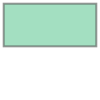

In [8]:
tags = {"amenity": True}

Paris = Polygon([(2.274507, 48.872479),
                 (2.351680, 48.872479),
                 (2.351680, 48.836947),
                 (2.274507, 48.836947),
                 (2.274507, 48.872479)])

Paris

## Load Data from OSM

In [9]:
START = get_time()

pois = ox.features_from_polygon(Paris, tags)

END = get_time()


print(f'Time to extarct data from OSM: {round(END-START,1)} seconds ({round((END-START)/60,1)} minutes)\n\n')

Time to extarct data from OSM: 53.1 seconds (0.9 minutes)




## Preprocess OSM data

In [10]:
pois = pois[['name', 'amenity', 'geometry']].dropna().rename(columns={'amenity':'place_type'}).to_crs(WGS84_UTM_31N)
pois['IsFood'] = pois.place_type.apply(lambda value: value in FOOD)

pois.head()

name      place_type  \
element id                                                  
node    21662099               Notre-Dame  ferry_terminal   
        29434739    Paris École Militaire     post_office   
        207782744           Paris Sentier     post_office   
        218117881  Parking Hôtel de Ville         parking   
        241110355  Bibliothèque Vaugirard         library   

                                         geometry  IsFood  
element id                                                 
node    21662099   POINT (452320.712 5411188.723)   False  
        29434739   POINT (449155.089 5411637.554)   False  
        207782744  POINT (452027.373 5412910.533)   False  
        218117881  POINT (452300.497 5411757.428)   False  
        241110355  POINT (448589.838 5410098.839)   False

## Display the ratio of food type POIs

In [11]:
is_food_rate = round(pois.IsFood.mean()*100,1)

print(f'{is_food_rate}% of POIs place_type are "Food related" (place_type = {FOOD})')


55.9% of POIs place_type are "Food related" (place_type = {'cafe', 'fast_food', 'restaurant'})


## POIs place_type statistics

In [12]:
pois.place_type.value_counts().head(10)

,count
place_type,
restaurant,2957
cafe,816
fast_food,778
bar,557
bank,306
school,287
bicycle_rental,277
pharmacy,239
place_of_worship,116


## Calculate the distance between each POI to Eiffel Tower

In [13]:
pois['distance_from_eiffel'] = pois.geometry.distance(EIFFEL).round(2)
pois.head()

name      place_type  \
element id                                                  
node    21662099               Notre-Dame  ferry_terminal   
        29434739    Paris École Militaire     post_office   
        207782744           Paris Sentier     post_office   
        218117881  Parking Hôtel de Ville         parking   
        241110355  Bibliothèque Vaugirard         library   

                                         geometry  IsFood  \
element id                                                  
node    21662099   POINT (452320.712 5411188.723)   False   
        29434739   POINT (449155.089 5411637.554)   False   
        207782744  POINT (452027.373 5412910.533)   False   
        218117881  POINT (452300.497 5411757.428)   False   
        241110355  POINT (448589.838 5410098.839)   False   

                   distance_from_eiffel  
element id                               
node    21662099                4142.15  
        29434739                 957.45  
        207782744               3901.01  
        218117881               4056.79  
        241110355               1876.56

## Select only the top 100 closest POIs to Eiffel Tower

In [14]:
top_k = 100

eiffel_radius = pois.sort_values('distance_from_eiffel').iloc[:top_k]

max_distance = eiffel_radius.distance_from_eiffel.round(1).iloc[-1]

print(f'The farthest entity from Eiffel Tower is in a distance of {max_distance} meters\n')

eiffel_radius.shape



The farthest entity from Eiffel Tower is in a distance of 540.7 meters



(100, 5)

## Display the ratio of food type POIs (only for the entities close to Eiffel Tower)

In [15]:
is_food_rate_eiffel = round(eiffel_radius.IsFood.mean()*100,1)

print(f'{is_food_rate_eiffel}% of POIs place_type are "Food related" (place_type = {FOOD})\n\n[Only for the closest {top_k} entities to Eiffel Tower]')


49.0% of POIs place_type are "Food related" (place_type = {'cafe', 'fast_food', 'restaurant'})

[Only for the closest 100 entities to Eiffel Tower]


## Display the closest POIs

In [16]:
locations = eiffel_radius.geometry.to_crs(WGS84_GEO_DD).apply(lambda geometry: geometry if geometry.geom_type=='Point' else geometry.centroid)

fmap = folium.Map(location=[eiffel_y,eiffel_x], zoom_start=16, width=1500, height=500)

for location, name in zip(locations, eiffel_radius.name):
    folium.Marker([location.y ,location.x],
                  tooltip=name,
                  zIndexOffset=-1,
                  icon=folium.Icon(color='green', icon='flag')).add_to(fmap)

folium.Marker([eiffel_y,eiffel_x],
              tooltip="Tour Eiffel",
              icon=folium.Icon(color='blue',
                               icon='star-empty'),
              zIndexOffset=100).add_to(fmap)

fmap

# --------------------------------------------------------------------------------

## Load Language model

Model documentation: [multilingual-e5](https://huggingface.co/intfloat/multilingual-e5-large)

In [17]:
MODEL = "intfloat/multilingual-e5-large"

TEXT = "restaurant"

embedder = pipeline("feature-extraction", model=MODEL)

get_text_embedding = lambda text: np.array(embedder(text)[0]).max(0)

get_text_embedding(TEXT)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


array([ 1.23215318,  0.75919527, -0.22321977, ..., -0.21436638,
       -0.85060573,  1.06850529])

## Create text embedding for each place name

In [18]:
eiffel_radius['repr'] = [get_text_embedding(text) for text in tqdm(eiffel_radius.name)]

eiffel_radius.head()

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


name       place_type  \
element id                                                 
way     308145239      Madame Brasserie       restaurant   
node    3135278479       Le Jules Verne       restaurant   
        3134285384    Paris Tour Eiffel      post_office   
        12801046288  Snacks Et Boissons        fast_food   
        3134287595     Caisse à billets  vending_machine   

                                                              geometry  \
element id                                                               
way     308145239    POLYGON ((448230.704 5411941.956, 448220.425 5...   
node    3135278479                       POINT (448251.491 5411925.21)   
        3134285384                      POINT (448251.664 5411906.687)   
        12801046288                     POINT (448281.755 5411971.577)   
        3134287595                       POINT (448196.353 5411939.74)   

                     IsFood  distance_from_eiffel  \
element id                                          
way     308145239      True                 10.87   
node    3135278479     True                 19.11   
        3134285384    False                 37.49   
        12801046288    True                 43.59   
        3134287595    False                 51.82   

                                                                  repr  
element id                                                              
way     308145239    [1.5537174940109253, 0.30982261896133423, 0.19...  
node    3135278479   [-0.6150434613227844, 0.5099130272865295, 0.22...  
        3134285384   [0.9651169180870056, 0.4774634838104248, 0.406...  
        12801046288  [1.0801328420639038, 0.6626097559928894, 0.310...  
        3134287595   [1.7954787015914917, 0.7984006404876709, 0.206...

## Query Embedding

In [19]:
QUERY = "I want something to eat"

food = get_text_embedding(QUERY)
food

array([ 1.13453996,  0.15420273,  0.09664137, ..., -0.4792431 ,
       -0.61367559,  0.1914511 ])

## Calculate distance between Query embedding to place name embedding

$x$ - Embedding vector of given POI place name

$q$ - Embedding vector of the input Query

$x,q \in \mathbb{R}^{n}$


distance functions:

 - L1 (Manhattan Distance): $L1(x, q) = \frac{1}{n}\sum_{i=1}^{n}|x_i-q_i|$
 - L2 (Euclidean Distance): $L2(x, q) = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_i-q_i)^{2}}$
 - CS (Cosine Similarity): $CS(x, q) = \frac{x^{t}q}{||x|| \cdot ||q||} $


##

In [20]:
cosine_similarity = lambda vec1, vec2: np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

eiffel_radius['L1'] = eiffel_radius.repr.apply(lambda ary:  np.abs(food-ary).mean())
eiffel_radius['L2'] = eiffel_radius.repr.apply(lambda ary: ((food-ary)**2).mean()**.5)
eiffel_radius['CS'] = eiffel_radius.repr.apply(lambda ary:  1-cosine_similarity(food,ary))
eiffel_radius['Random'] = np.random.rand(eiffel_radius.shape[0])

eiffel_radius.head()

name       place_type  \
element id                                                 
way     308145239      Madame Brasserie       restaurant   
node    3135278479       Le Jules Verne       restaurant   
        3134285384    Paris Tour Eiffel      post_office   
        12801046288  Snacks Et Boissons        fast_food   
        3134287595     Caisse à billets  vending_machine   

                                                              geometry  \
element id                                                               
way     308145239    POLYGON ((448230.704 5411941.956, 448220.425 5...   
node    3135278479                       POINT (448251.491 5411925.21)   
        3134285384                      POINT (448251.664 5411906.687)   
        12801046288                     POINT (448281.755 5411971.577)   
        3134287595                       POINT (448196.353 5411939.74)   

                     IsFood  distance_from_eiffel  \
element id                                          
way     308145239      True                 10.87   
node    3135278479     True                 19.11   
        3134285384    False                 37.49   
        12801046288    True                 43.59   
        3134287595    False                 51.82   

                                                                  repr  \
element id                                                               
way     308145239    [1.5537174940109253, 0.30982261896133423, 0.19...   
node    3135278479   [-0.6150434613227844, 0.5099130272865295, 0.22...   
        3134285384   [0.9651169180870056, 0.4774634838104248, 0.406...   
        12801046288  [1.0801328420639038, 0.6626097559928894, 0.310...   
        3134287595   [1.7954787015914917, 0.7984006404876709, 0.206...   

                           L1        L2        CS    Random  
element id                                                   
way     308145239    0.531372  0.655193  0.220901  0.769413  
node    3135278479   0.501194  0.631817  0.205022  0.559729  
        3134285384   0.545549  0.680671  0.239514  0.237572  
        12801046288  0.439308  0.551759  0.158156  0.215896  
        3134287595   0.527293  0.664171  0.228037  0.018718

## Evaluate each distance method performance

Using Precision@K, where $K \in [5, 100]$

In [21]:

Ks = [5, 10, 25, 50, top_k]

required_columns = [*eiffel_radius.columns[-4:]]+['distance_from_eiffel']

evaluation = {method:{k:0 for k in Ks} for method in required_columns}

for method in required_columns:
    for k in Ks:
      evaluation[method][k] = eiffel_radius.sort_values(method).IsFood[:k].mean()

evaluation = pd.DataFrame(evaluation)*100
evaluation.round(1)


,L1,L2,CS,Random,distance_from_eiffel
5,100.0,100.0,80.0,40.0,60.0
10,80.0,80.0,80.0,50.0,60.0
25,80.0,80.0,76.0,48.0,48.0
50,60.0,62.0,60.0,56.0,44.0
100,49.0,49.0,49.0,49.0,49.0


## Display evaluation results as a figure

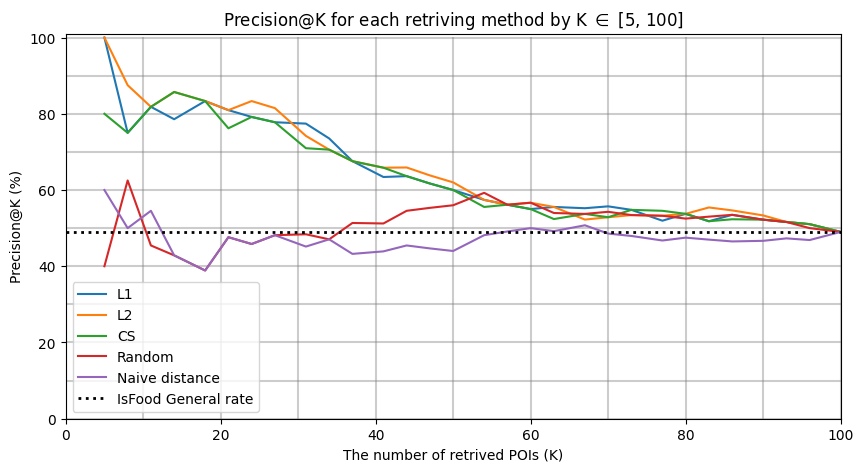

In [22]:
Ks = [int(n) for n in np.linspace(5, top_k, 30)]

required_columns = [*eiffel_radius.columns[-4:]]+['distance_from_eiffel']

evaluation = {method:{k:0 for k in Ks} for method in required_columns}

for method in required_columns:
    for k in Ks:
        eiffel_radius.sort_values(method).IsFood[:k].mean()
        evaluation[method][k] = eiffel_radius.sort_values(method).IsFood[:k].mean()

evaluation = pd.DataFrame(evaluation)*100

# ##############################################################################

plt.figure(figsize=(10,5))
plt.title(f'Precision@K for each retriving method by K $\\in$ [5, {top_k}]')
for col in evaluation.columns:
    plt.plot(evaluation.index, evaluation[col], label=col if col!='distance_from_eiffel' else 'Naive distance')

plt.plot([0, top_k], [is_food_rate_eiffel, is_food_rate_eiffel],
         color='k', lw=2, linestyle='dotted', label = 'IsFood General rate')

for yi in np.linspace(0,100,11):
    plt.plot([0,top_k],[yi,yi], color='gray', alpha=.4, zorder=-1)

for xi in np.linspace(0,top_k,11):
    plt.plot([xi, xi],[0,100], color='gray', alpha=.4, zorder=-1)

plt.xlabel('The number of retrived POIs (K)')
plt.ylabel('Precision@K (%)')

plt.legend(loc='lower left')
plt.ylim(0,101)
plt.xlim(0,top_k)

plt.show()



# Find the metric with the higher Precision for each K

In [23]:
higher_score_column = evaluation.idxmax(axis=1).value_counts().index[0]

print(f'The column with the higher score is {higher_score_column}')

The column with the higher score is L1


## Display the top restults by the optimal metric

In [24]:
N_best_locations = 10

best_locations = eiffel_radius.sort_values(higher_score_column).iloc[:N_best_locations]
best_locations_xy = best_locations.geometry.to_crs(WGS84_GEO_DD).apply(lambda geometry: geometry if geometry.geom_type=='Point' else geometry.centroid)

fmap = folium.Map(location=[eiffel_y,eiffel_x], zoom_start=15, width=1500, height=500)

for location, name in zip(best_locations_xy, best_locations.name):
    folium.Marker([location.y ,location.x],
                  tooltip=name,
                  zIndexOffset=100,
                  icon=folium.Icon(color='red', icon='cutlery')).add_to(fmap)

folium.Marker([eiffel_y,eiffel_x],
              tooltip="Tour Eiffel",
              icon=folium.Icon(color='blue',
                               icon='star-empty'),
              zIndexOffset=200).add_to(fmap)

fmap

# Bon appétit!

Create by Etzion Harari | Geo-AI Course | [https://github.com/EtzionR/LM4GeoAI](https://github.com/EtzionR/LM4GeoAI)